# Course Project

### Guilherme Gil, Alva Ringi & Francisco Simões

## Dataset

You will examine the ProPublica COMPAS dataset, which consists of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were also gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date, risk of recidivism predicted by the COMPAS tool). Finally, the dataset also contains information about whether the defendant did actually recidivate or not.

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project goal

The project has three parts: 

1. The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

2. Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier. 

3. Build a fair classifier (last lecture will cover fair classification techniques). Is excluding the race from the feature set enough?


In [ ]:
# installations that might be needed to run this notebook

# !pip3 install sklego
# !pip3 install cvxpy
# !pip3 install tensorflow
# !pip3 install seaborn
# !pip3 install sklearn

## Load the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


In [2]:
import urllib
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,confusion_matrix

from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)
pd.set_option('display.max_columns', None)
def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

df = pd.read_csv(COMPAS_INPUT_FILE)

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


# Part 1: Analysis of the dataset and its biases

- **The dataset contains data on how many convicts?** 

In [ ]:
print("There are ", df.shape[0], "samples in the dataset.")

- **What are the features the dataset contains?**

In [ ]:
df.head()

- **Are there missing values (NaN)? are there outliers?**

In [ ]:
print("Number of NaN values: ", df.isnull().sum().sum())

- **Does ProPublica mentions how to clean the data?** 

Yes, in the article "How We Analyzed the COMPAS Recidivism Algorithm" (https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) ProPublica describes how they cleaned the data. One part of their cleaning was done through the function which is described below.

Furthermore the ProPublica article "Machine Bias Risk Assessments in Crinimal Sentencing"(https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) discusses what features that should and should not be used for predicting recidivism. Brennan who represents Northpointe that is behind the COMPAS assessment sais that removing all featuers that are in someway correlated to race would give a very low accuracy. There will always be a tradeoff between fairness and accuracy. 

- **What is the effect of the following function?**

In [3]:
print(df.shape)
df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals
df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]
df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
print(df.shape)

(7214, 53)
(6172, 53)


**Comment**: It first removes all rows in the dataset that have no value for the feature "days before screening arrest". The we drop rows where the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested because maybe they don't have the right offense. If there's no compas case, the column "is_recid" is marked as -1 so we can also drop these rows. Offenses with a charge degree of 'O' won't result in jail time so we will also not consider the rows with this value. Then we also drop the rows in which the column "score_text" has the value 'N/A'.

## Basic analysis of demographics

- **What are the different races present in the dataset?** 

In [ ]:
df["race"].unique().tolist()

- **What is the number of people by age category?**

In [ ]:
age_cat_names = list(df["age_cat"].unique().tolist())
age_cat_size = list(df.groupby(["age_cat"], sort=False).size())
plt.bar(age_cat_names, age_cat_size)
plt.title("Number of people per age category")
plt.show()

**Comment**: There is a majority of people in the dataset are between 25 and 45 years old.

- **What is the number of people by COMPAS score (decile_score)?**

In [ ]:
decile_score_names = list(df["decile_score"].unique().tolist())
decile_score_size = list(df.groupby("decile_score", sort=False).size())
plt.bar(decile_score_names, decile_score_size)
plt.title("Number of people per COMPAS score")
plt.show()

**Comment**: The by far most common score is 1. The higher score, the less common.

- **What is the number of people by COMPAS risk category (score_text)?**

In [ ]:
score_text_names = list(df["score_text"].unique().tolist())
score_text_size = list(df.groupby("score_text", sort=False).size())
plt.bar(score_text_names, score_text_size)
plt.title("Number of people per COMPAS risk category")
plt.show()

**Comment**: The by far most common class is "low score", followed by "medium" and "high". This follows well the distribution of the numerical scores observed in the plot above.

- **What is the number of people by race?**

In [ ]:
race_names = list(df["race"].unique().tolist())
race_size = list(df.groupby("race", sort=False).size())
plt.bar(race_names, race_size)
plt.xticks(rotation=20)
plt.title("Number of people per race")
plt.show()

**Comment**: There are very few Native American and Asian people in this dataset. We do not think there are enough people in these groups to have an unbiased estimator for them. For this reason, we will remove the categories "Native American" and "Asian" and place these samples in the category "Other".

In [ ]:
df.loc[(df.race == 'Asian'),'race']='Other'
df.loc[(df.race == 'Native American'),'race']='Other'

## Basic investigations of gender and race bias in COMPAS scores

- **What is the mean COMPAS score (decile_score) per race and gender?** 

In [ ]:
# mean score per race
race_names = list(df["race"].unique().tolist())
race_score_mean = list(df.groupby(["race"], sort=False).mean()["decile_score"])
plt.bar(race_names, race_score_mean)
plt.title("Mean COMPAS score per race")
plt.show()

# mean score per gender
sex_names = list(df["sex"].unique().tolist())
sex_score_mean = list(df.groupby(["sex"], sort=False).mean()["decile_score"])
plt.bar(sex_names, sex_score_mean)
plt.title("Mean COMPAS score per gender")
plt.show()

**Comment**: The mean score is the highest for the race group "African-American". For men women, the mean score is similar.

- **What is the distribution (histogram) of decile_score per race and gender?**

In [ ]:
# decile score per race
df.hist(column='decile_score', by=["race"],figsize = (9,7));
plt.show()

# decile score per gender
df.hist(column='decile_score', by=["sex"],figsize = (9,3));
plt.show()

**Comment**: For the African American people the histogram distribution on this race is more evenly distributed when compared to the other races histograms (we can observe a higher percentage of higher scores in the African American race). For the other races we can see that the histogram is more squewed to lower values.

Comparing men and women, we see that the decile score distribution is similar for the two genders.

- **How many people were re-arrested?** 

In [ ]:
rearrested = df[df["two_year_recid"]==1]
print("Number of Re-arrests:", len(rearrested.index))

- **Compute the recidivism (i.e., people that got re-arrested) rates by race and gender**

In [ ]:
# calculate number of re-arrested people as well as total number of people per race
races_names = list(df["race"].unique().tolist())
race_nr_ra = list(df.loc[(df['two_year_recid'] == 0)].groupby(["race"], sort=False).size())
race_nr = list(df.groupby(["race"], sort=False).size())

# calculate ratios per race
race_ra_rate = []
for i in range(len(races_names)):
    race_ra_rate.append(1-(race_nr_ra[i] / race_nr[i]))

# plot result
plt.bar(race_names, race_ra_rate)
plt.title("Recidivism rate per race")
plt.show()

# calculate number of re-arrested people as well as total number of people per gender
sex_names = list(df["sex"].unique().tolist())
sex_nr_ra = list(df.loc[(df['two_year_recid'] == 0)].groupby(["sex"], sort=False).size())
sex_nr = list(df.groupby(["sex"], sort=False).size())

# calculate ratios per gender
sex_ra_rate = []
for i in range(len(sex_names)):
    sex_ra_rate.append(1-(sex_nr_ra[i] / sex_nr[i]))

# plot result    
plt.bar(sex_names, sex_ra_rate)
plt.title("Recidivism rate per sex")
plt.show()

**Comment**: The recidivism rate is higher for African-Americans compared to the other races. This indicates that the dataset itself is bias. With a bias dataset, classifiers will learn these patterns and, in this case, give higher decile scores to African-Americans.

Comparing genders, the recidivism rate is higher for men than women. This is not as clearly reflected in the decile scores as in the case with race. The mean decile score for men and women is more equal than the recidivism rate in the dataset.

In [ ]:
dfr = df[["decile_score","two_year_recid","sex","race"]]

def is_recid(row):
    if(row["decile_score"] >= 5):
        return 1
    else:
        return 0
    
dfr['pred_is_recid'] = dfr.apply (lambda row: is_recid(row), axis=1)
dfr.head()


**Comment**: We consider any decile scores equal or above 5 to be a positive recidivism prediction since the decile score goes from 1 to 10.

- **What is the accuracy of the COMPAS scores to predict recidivism**

In [ ]:
accuracy_score(dfr["two_year_recid"], dfr["pred_is_recid"])

- **Is the accuracy higher/lower if we look at particular races/genders?**

In [ ]:
races = df["race"].unique().tolist()
genders = ["Male","Female"]
for race in races:
    aux_df = dfr.loc[dfr['race'] == race]
    acc = accuracy_score(aux_df["two_year_recid"], aux_df["pred_is_recid"])
    print("Accuracy for {race} is {acc}".format(race = race, acc = acc))

for sex in genders:
    aux_df = dfr.loc[dfr['sex'] == sex]
    acc = accuracy_score(aux_df["two_year_recid"], aux_df["pred_is_recid"])
    print("Accuracy for {sex} is {acc}".format(sex = sex, acc = acc))

**Comment**: The accuracy seems to be lower for African-Americans than for any other race, which might indicate the existence of some bias. As for gender, both accuracies are extremely similar.

- **What about false positives and false negatives?**

In [4]:
def makeCM (dfr,label):
    cf_matrix = confusion_matrix(dfr["two_year_recid"], dfr["pred_is_recid"])

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix for ' + label);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [5]:
def DisplayCM (cf_matrix, label):  
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix for ' + label);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [ ]:
races = df["race"].unique().tolist()
genders = ["Male","Female"]

for race in races:
    aux_df = dfr.loc[dfr['race'] == race]
    makeCM(aux_df,race)  

for sex in genders:
    aux_df = dfr.loc[dfr['sex'] == sex]
    makeCM(aux_df,sex)

**Comment**: From the confusion matrices we can see that the false positive rate is highest among African-Americans indicating that there's a bias against them. The opposite can be found for the other races. The False Negatives is then lower for African-Americans than for other races meaning that the model does a bad job at identifying people that will recomit a crime if they are not African-American.

We can also notice extreme percentages in the Native American matrix, but this is caused a by a very low number of Native-Americans in this sample, so we can't really draw any conclusions from this result.

Comparing the confusion matricies for men and women we can see that the false positive rate is higher for women and for men, which means that women that are predicted to recidivate are more likely to not recidivate than men that are predicted to recidivate. Furthermore, the false negative rate is lower for women than men women. This means that women that are predicted to not recidivate do recidivate in a less extent than men that are predicted to recidivate. This indicates that there is a bias against women.

For the following parts of this project we will focus on the biases regarding race and not gender. Analyzing more than one sensitive class makes the analysis more complex which we feel that we do not have time for within the scope of this project.

**Comment**: Since the results we obtained with a static universal threshold of 5 for every race were not ideal, we decided to try diferent variations of thresholds for both Caucasian and African-American in order to try to achieve values of Positive Rate (Demografic Parity) and True Positive Rate (Equal Oportunity) that are closer in both classes.

In [ ]:
dft = df[["decile_score","two_year_recid","race"]]

In [ ]:
#function to apply the threshold to the data and transform the decile score to a binary variable
def is_recid2(row,bt,wt):
    if(row["race"] == "African-American"):
        if(row["decile_score"] >= bt):
            return 1
        else:
            return 0
    if(row["race"] == "Caucasian"):
        if(row["decile_score"] >= wt):
            return 1
        else:
            return 0
    else:
        if(row["decile_score"] >= 5):
            return 1
        else:
            return 0

In [ ]:
#function that does the math around true positive rates and calculates the diference between them
def process_equalOpt(bt,wt):
    df_curr = dft.copy()
    df_curr['pred_is_recid'] = df_curr.apply (lambda row: is_recid2(row,bt,wt), axis=1)

    dfa = df_curr[df_curr["race"] == "African-American"]
    dfw = df_curr[df_curr["race"] == "Caucasian"]

    [[a_tn , a_fp],[a_fn , a_tp]]  = confusion_matrix(dfa['two_year_recid'], dfa['pred_is_recid'])

    [[w_tn , w_fp],[w_fn , w_tp]]  = confusion_matrix(dfw['two_year_recid'], dfw['pred_is_recid'])


    a_tpr = a_tp / (a_tp + a_fn)

    w_tpr = w_tp / (w_tp + w_fn)
    
    diff = w_tpr - a_tpr
    
    return diff


In [ ]:
#function that does the math around positive rates and calculates the diference between them
def process_demoPar(bt,wt):
    df_curr = dft.copy()
    df_curr['pred_is_recid'] = df_curr.apply (lambda row: is_recid2(row,bt,wt), axis=1)

    dfa = df_curr[df_curr["race"] == "African-American"]
    dfw = df_curr[df_curr["race"] == "Caucasian"]

    [[a_tn , a_fp],[a_fn , a_tp]]  = confusion_matrix(dfa['two_year_recid'], dfa['pred_is_recid'])

    [[w_tn , w_fp],[w_fn , w_tp]]  = confusion_matrix(dfw['two_year_recid'], dfw['pred_is_recid'])


    a_pr = (a_tp + a_fp) / (a_tp + a_fn + a_tn + a_fp)

    w_pr = (w_tp + w_fp) / (w_tp + w_fn + w_tn + w_fp)
    
    diff = w_pr - a_pr
    
    return diff


In [ ]:
#piece of code to figure how the best thresholds for the Equal Oportunities fairness criteria
a_thresholds = [6,7,8]

w_thresholds = [4,3,2]

min_dif = 100000000000000

curr_dif = 10000000000000

best_a_threshold = 0

best_w_threshold = 0

for i in a_thresholds:
    for j in w_thresholds:
        curr_dif = process_equalOpt(i,j)
        print("Diff for a_threshold " + str(i) + " and w_treshold " + str(j) + " is " + str(curr_dif))
        if(curr_dif < min_dif):
            min_dif = curr_dif
            best_a_threshold = i
            best_w_threshold = j

print("Best a_treshold: " + str(best_a_threshold))
print("Best w_treshold: " + str(best_w_threshold))


In [ ]:
#piece of code to figure how the best thresholds for the Demographic Parity fairness criteria
a_thresholds = [6,7,8]

w_thresholds = [4,3,2]

min_dif = 100000000000000

curr_dif = 10000000000000

best_a_threshold = 0

best_w_threshold = 0

for i in a_thresholds:
    for j in w_thresholds:
        curr_dif = process_demoPar(i,j)
        print("Diff for a_threshold " + str(i) + " and w_treshold " + str(j) + " is " + str(curr_dif))
        if(curr_dif < min_dif):
            min_dif = curr_dif
            best_a_threshold = i
            best_w_threshold = j

print("Best a_treshold: " + str(best_a_threshold))
print("Best w_treshold: " + str(best_w_threshold))


**Comment**: After running the code, we came to the conclusion that for both fairness criteria the best thresholds are 6 for african-american and 4 for caucasian.

In [ ]:
df_curr = dft.copy()
df_curr['pred_is_recid'] = df_curr.apply (lambda row: is_recid2(row,6,4), axis=1)

dfa = df_curr[df_curr["race"] == "African-American"]
dfw = df_curr[df_curr["race"] == "Caucasian"]

a_cm  = confusion_matrix(dfa['two_year_recid'], dfa['pred_is_recid'])

w_cm  = confusion_matrix(dfw['two_year_recid'], dfw['pred_is_recid'])

print("Threshold of 6 for African-American and Threshold of 4 for Caucasian")
DisplayCM(a_cm,"African-American")
DisplayCM(w_cm,"Caucasian")

In [ ]:
races = ["African-American","Caucasian"]

print("Universal threshold of 5")
for race in races:
    aux_df = dfr.loc[dfr['race'] == race]
    makeCM(aux_df,race) 

**Comment**: When comparing the confusion matrices we can clearly see that with the thresholds of 6 for african-american and 4 for caucasian that the values between those two races are much closer to each other compared to when we had a universal threshold of 5 for every race.

In [ ]:
#Accuracy for threshold of 6 for african-american and 4 for caucasian
accuracy_score(df_curr["two_year_recid"], df_curr["pred_is_recid"])

In [ ]:
#Accuracy for a universal threshold of 5
accuracy_score(dfr["two_year_recid"], dfr["pred_is_recid"])

**Comment**: As we can see to get a better confusion matrix with different thresholds we have an accuracy trade-off.

# Choosing Features

**Comment**: Below we choose what features to use when training our algorithms. We have chosen to use:
- **Sex**: Female, male
- **Age category**: (<25, 25-45, >45 years) 
- **Charge degree**: Misdemeanors, felony
- **Race**: African american, caucasian, hispanic and others (including asian and native american since we have too little data to analyze these races independently)
- **Priors count**: Number of earlier crimes
- **Juvenile mesdemeanor count**: Number of juvenile crimes, misdemeanors
- **Juvenile felony count**: Number of juvenile crimes, felonies
- **Juvenile other count**: Number of juvenile crimes, neither misdemanors nor felonies
- **Two years recid**: Ground truth

Features like e.g. names and dates are not being used since we do not consider them interesting for the prediction. 

We also make all features numerical (using the function "OneHotEncoder") since some algorithms for classifying can only handle numerical data. 

In [6]:
# choose features
dfa = df[["sex","age_cat","race","priors_count","two_year_recid","juv_misd_count","juv_fel_count","juv_other_count","c_charge_degree"]]

In [7]:
# merge race groups "asian" and "native american" with "other"
dfa.loc[(df.race == 'Asian'),'race']='Other'
dfa.loc[(df.race == 'Native American'),'race']='Other'

In [8]:
# make non-numerical features numerical
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(), ['sex', 'age_cat',"c_charge_degree","race"]),
    remainder='passthrough')
d = column_trans.fit_transform(dfa)

In [9]:
# clean labels
labels = column_trans.get_feature_names_out()

def cleanLabels(label):
    if("onehotencoder__" in label):
        return label.removeprefix("onehotencoder__")
    else:
        return label.removeprefix("remainder__")
cleanedLabels = map(cleanLabels,labels)
listedLabels = list(map(cleanLabels,labels))

In [10]:
# create new dataframe with only numerical data
df_cleaned = pd.DataFrame(data=d,columns=cleanedLabels)

In [12]:
from sklearn.preprocessing import StandardScaler
labels = ["priors_count","juv_misd_count","juv_fel_count","juv_other_count"]
to_scale = df_cleaned[labels]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(to_scale)
df_scaled =  pd.DataFrame(data=scaled_data,columns = labels)
df_cleaned.drop(columns = labels, inplace = True)
dfa_num = pd.concat([df_cleaned,df_scaled], axis=1)
dfa_num

,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_F,c_charge_degree_M,race_African-American,race_Caucasian,race_Hispanic,race_Other,two_year_recid,priors_count,juv_misd_count,juv_fel_count,juv_other_count
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.684413,-0.183232,-0.127923,-0.235102
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.684413,-0.183232,-0.127923,-0.235102
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.158866,-0.183232,-0.127923,1.889425
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.684413,-0.183232,-0.127923,-0.235102
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.267065,-0.183232,-0.127923,-0.235102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.684413,-0.183232,-0.127923,-0.235102
6168,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.684413,-0.183232,-0.127923,-0.235102
6169,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.684413,-0.183232,-0.127923,-0.235102
6170,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.051954,-0.183232,-0.127923,-0.235102


# Part 2: Train Classifiers

**Comment**: Below we randomly split our data into a training set (70% of the dataset) and a test set (30% of the dataset). 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklego.metrics import p_percent_score
from sklego.metrics import equal_opportunity_score
Y = dfa_num["two_year_recid"]
X = dfa_num.drop(columns="two_year_recid")

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.30, random_state=42)

In [14]:
def SetupMatrix(cf, normalize):
    predictions = cf.predict(X_test)
    if normalize:
        for p in predictions:
            if p[0]>=0.5:
                p[0] = 1
            else:
                p[0] = 0 
    cm_data = X_test.copy() # do we change X_test by doing this? If so, we can't do this
    cm_data["two_year_recid"] = y_test
    cm_data["predictions"] = predictions # add the predictions to the table with data
    
    
    races = ["race_African-American","race_Caucasian","race_Hispanic","race_Other"]

    for race in races:
        cm_data_filtered = cm_data.loc[cm_data[race] == 1.0]
        cm = confusion_matrix(cm_data_filtered["two_year_recid"], cm_data_filtered["predictions"])
        DisplayCM(cm, race)

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test,y_test)
#cross validation for reg

0.6695464362850972

In [16]:
scores = []
for c in np.arange (0.01, 1, 0.05):
    clf = LogisticRegression(random_state=0,C = c)
    cv = cross_validate(clf, X_train, y_train, cv=10,scoring='f1_macro')
    score = np.mean(cv["test_score"])
    scores.append([score,c])
reg = max(scores)
print(reg)

[0.6612737105016528, 0.46]


In [ ]:
clf = LogisticRegression(random_state=0,C = reg[1] ).fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test,y_test)

In [ ]:
# confusion matrices for logistic regression
SetupMatrix(clf,0)

**Comment**: Our Logistic Regression model has a higher False Positive rate for African-Americans when compared to the other races. However, it's an improvement from the COMPAS predictor since our False Positive rate is significantly lower (at the cost of a small hit on the True Positive rate). Yet, it's still higher than the other races' rates. In fact, the other races present a fairly high False Negative rate, meaning a lot of people predicted to not re-commit crimes will actually do so. Our False Negative rates are worse than the COMPAS' ones.

In [ ]:
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(clf, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(clf, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(clf, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(clf, X)))

**Comment**: The P-scores are higher for Caucasians and Hispanics than for African-Americans and "Others", which prompts us to think there might be a bias against these 2 groups. But these values are not extreme, they seem to be fairly regular values.

In [ ]:
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(clf, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(clf, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(clf, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(clf, X,Y)))

**Comment**: The equal opportunity score measuers how far from equal opportunity (definition can be found in the fairness part of this notebook) a classifier is. 1 is perfect and 0 is the worst. For our logistic regression classifier, we can se that the score is higher for caucasians than the other races which means that the classifier favours white (caucasian) people.

### Importance of features

In [ ]:
importance = clf.coef_[0]
# summarize feature importance
j = 0
for i,v in enumerate(importance):
    print('Feature: %0s, Score: %.5f' % (listedLabels[j],v))
    j += 1
# plot feature importance
print(len(listedLabels))
print(len(importance))
plt.figure(figsize=(10, 5), dpi=80)
plt.bar(listedLabels[:-1], importance)
plt.rcParams['font.size'] = '25'
plt.xticks(rotation=90)
plt.show()

**Comment**: The most important feature for predicting recidivism is age. An age under 25 increases the risk of being predicted as high risk. An age over 45 lowers the risk of being predicted high risk. The second most importent features are related to earlier commited crimes. Considering race, african americans and caucasians are more likely to be predicted as high risk than hispanics and others.

## SVC

In [ ]:
from sklearn.svm import SVC
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc.fit(X_train, y_train)
svc.score(X_test,y_test)
pred = svc.predict(X_test)
print( "Accuracy " + str(svc.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

In [ ]:
scores = []
for c in np.arange (0.01, 1, 0.05):
    svc = make_pipeline(StandardScaler(), SVC(gamma='auto', C = c))
    cv = cross_validate(svc, X_train, y_train, cv=10)
    score = np.mean(cv["test_score"])
    scores.append([score,c])
reg = max(scores)
print(reg)

In [ ]:
best_svc = make_pipeline(StandardScaler(), SVC(gamma='auto',C = reg[1]))
best_svc.fit(X_train, y_train)
pred = best_svc.predict(X_test)
print( "Accuracy " + str(best_svc.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

In [ ]:
# confusion matrices for SVC
SetupMatrix(best_svc,0)

**Comment**: Just like for the Logistic Regression, we're able to improve the False Positive rate for the African-Americans slightly, yet this value is still higher when compared to the other races. And we can draw the same conclusion regarding the False Negative rates being too high, higher than the COMPAS' rates.

In [ ]:
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(best_svc, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(best_svc, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(best_svc, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(best_svc, X)))

**Comment**: The P-scores are higher for Caucasians and Hispanics than for African-Americans and "Others", which means we still have values that are too low for these groups. They are particularly high for Hispanics which wasn't something we expected initially.

In [ ]:
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(best_svc, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(best_svc, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(best_svc, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(best_svc, X,Y)))

**Comment**: For our SVC classifier, the equal opportunity scores for the different races are more spread out compared to the logistic regression classifier above. The classifier is not doing good in having equal opportunity for the different races.

## Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k_scores = []
for k in range(3,12,2):
    neigh = KNeighborsClassifier(n_neighbors=k)
    cv = cross_validate(neigh, X_train, y_train, cv=5)
    k_score = np.mean(cv["test_score"])
    k_scores.append([k_score,k])
k_reg = max(k_scores)
print(k_reg)

In [ ]:
best_neigh = KNeighborsClassifier(n_neighbors=k_reg[1])
best_neigh.fit(X_train, y_train)
pred = best_neigh.predict(X_test)
print( "Accuracy " + str(best_neigh.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

In [ ]:
# confusion matrices for Nearest Neighbors
SetupMatrix(best_neigh,0)

**Comment**: We seem to have an improvement on this classifier regarding the False Positive rates. These have a much smaller variation between races, meaning we're heading torwards a fairer model. We're also able to drop the False Negative rates slightly compared to the previous classifiers, edging closer to the COMPAS' rates.

In [ ]:
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(best_neigh, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(best_neigh, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(best_neigh, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(best_neigh, X)))

**Comment**: The P-scores are highest for Caucasians and then for Hispanics, but we don't see a large disparity between those values and the ones for "Others" or African-Americans. These are very large p-scores, so we can conclude these values are more "regular" values and means we're getting closer to fairer classifications.

In [ ]:
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(best_neigh, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(best_neigh, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(best_neigh, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(best_neigh, X,Y)))

**Comment**: The equal opportunity scores for our NN-classifier are similar for all races and also higher compared to the logistic regression and SVC classifiers. The NN-classifier is comparably fair considering equal opportunity for different races.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
##code from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)


In [ ]:
best_rf = RandomForestClassifier(max_depth=rf_random.best_params_["max_depth"], random_state=0, n_estimators=rf_random.best_params_["n_estimators"],min_samples_split=rf_random.best_params_["min_samples_split"],min_samples_leaf=rf_random.best_params_["min_samples_leaf"],max_features=rf_random.best_params_["max_features"],bootstrap=rf_random.best_params_["bootstrap"])
best_rf.fit(X_train, y_train)
pred = best_rf.predict(X_test)
print( "Accuracy " + str(best_rf.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

In [ ]:
# confusion matrices for Random Forest
SetupMatrix(best_rf,0)

**Comment**: With this model, we achieve a lower False Positive rate for African-Americans while maintaining a slightly lower rate for the other races. The False Negative rates are still within the expected values (similar to Nearest Neighbors).

In [ ]:
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(best_rf, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(best_rf, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(best_rf, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(best_rf, X)))

**Comment**: The P-scores are highest for Hispanics by quite a lot and we didn't expect to see such a high difference. The lowest scores still go to African-Americans. These scores are not as good as the ones obtained in the Nearest Neighbors classifier.

In [ ]:
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(best_rf, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(best_rf, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(best_rf, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(best_rf, X,Y)))

**Comment**: The equal opportunity scores for the random forest classifier is following the same pattern as for the logistic regression classifier: similar scores for all races excpet for caucasians for which the score is higher which indicates that caucasians are favoured by the classifier. Compared to the logistic regression classifer the scores are, in over all, higher for the random forest classifer, which means that the random forest is performing better than the logistic regression classifier considering equal opportunity for different races.

## Neural Network

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1024      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 8)                 136       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
432/432 [==============================]

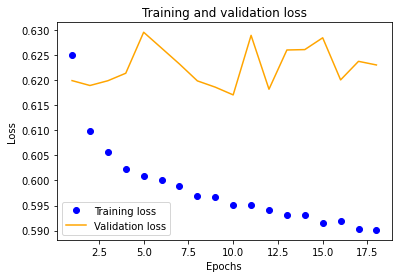

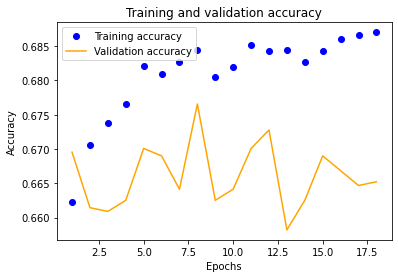

Test accuracy: 0.6765658855438232


In [27]:
#https://medium.com/luca-chuangs-bapm-notes/build-a-neural-network-in-python-binary-classification-49596d7dcabf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


model = Sequential()
model.add(Dense(64, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=500, # you can set this to a big number!
                    batch_size=10,
                    validation_data=(X_test,y_test),
                    shuffle=True,
                    verbose=1)



history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
#np.max(val_acc)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

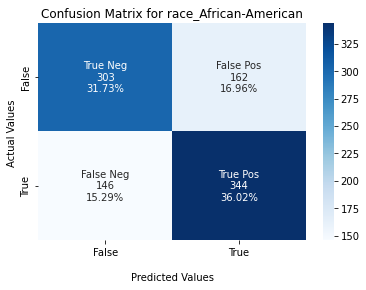

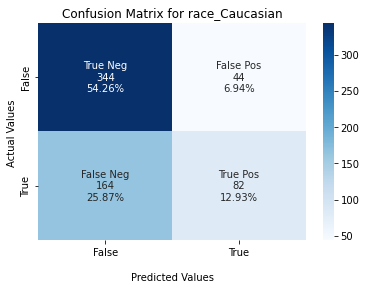

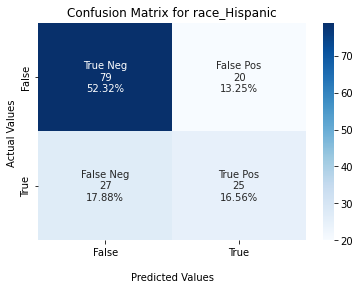

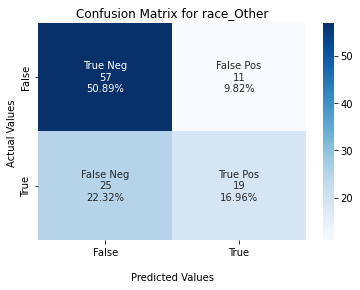

In [28]:
# confusion matrices for Neural Network
SetupMatrix(model, 1)

**Comment**: Our results with the Neural Network are similar to COMPAS, except with the improvement on the False Positive rate, meaning we're not falsefully predicting as many people to re-commit crimes as COMPAS. So we get a strong True Positive rate and a decent False Positive, a vast improvement from COMPAS and one of the best classifiers we trained.

We were not able to evaluate the p-score and the equal opportunity score on the neural network since the metrics need a model as parameter. 

## Conclusions on trained classifiers

The classifier that most consistently got the best results was the Neural Network. This classifier was consistently able to get some of highest True Positive and True Negative rates as well lowering the False Negative and False Positive rates. For the African-American race, it's able to make it lower than the other ones consistently and the False Positive rates for the other races don't get very high either. It also mantains a lower False Negative rate, meaning it doesn't under-predict recidivism very often. And the True Positive rate for the African-American is still usually higher than on the other classifiers. If we check the overall accuracy, it usually has the highest one out of all the classifiers.

For these reasons, we consider the Neural Network to be the best choice.

# Part 3: Fair classifiers

Based on the article "How to define fairness to detect and prevent discriminatory outcomes in Machine Learning" (Towards Data Science, 2019, https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2), there are three different perspectives on fairness in machine learning:

- **Demographic Parity**: Demographic Parity means that the proportion of each segment of a protected class receives positive outcomes at equal rates. In mathematical terms, Demographic Parity requires the outcome to be independent of the protected class A. With regard to the confusion matrix, we require the Positive Rate (PR) to be the same for each segment of the protected class.

- **Equal Opportunity**: Equal Opportunity states that each group should get the positive outcome at equal rates, assuming that people in this group qualify for it. Equal Opportunity requires the positive outcome to be independent of the protected class A, conditional on Y being an actual positive. Based on the confusion matrix, we require the True Positive Rate (TPR) to be the same for each segment of the protected class.

- **Equalised Odds**: Correctly identify the positive outcome at equal rates across groups (same as in Equal Opportunity), but also miss-classify the positive outcome at equal rates across groups (creating the same proportion of False Positives across groups). Equalised Odds requires the positive outcome to be independent of the protected class A, conditional on the actual Y. In the confusion matrix, this means that the True Positive Rate (TPR) and False Positive Rate (FPR) should be the same for each segment of the protected class.


All three definitions can not be fullfilled at the same time. In this project we will look more into the demographic parity and the opportunity for the different races in the dataset.

In search for more fair classifiers we found two variations of logistic regression: DemographicParityClassifier and EqualOpportunityClassifier: https://scikit-lego.readthedocs.io/en/latest/fairness.html

The DemographicParityClassifier takes into consideration the p% score but since it's a non-convex function it instead aproximates this function by taking the covariance between the users’ sensitive attributes and the decision boundary. 

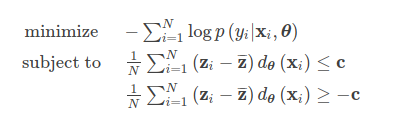

In [19]:
from sklego.linear_model import DemographicParityClassifier
from sklego.metrics import p_percent_score

demo_parity = DemographicParityClassifier(sensitive_cols=["race_African-American","race_Caucasian","race_Hispanic","race_Other"], covariance_threshold=0.5)
demo_parity.fit(X_train, y_train)

OneVsRestClassifier(estimator=_DemographicParityClassifier(covariance_threshold=0.5,
                                                           sensitive_cols=['race_African-American',
                                                                           'race_Caucasian',
                                                                           'race_Hispanic',
                                                                           'race_Other']),
                    n_jobs=1)

In [ ]:
demo_parity.predict(X_test)

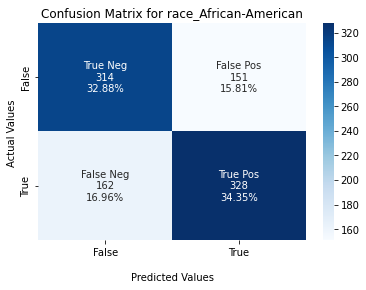

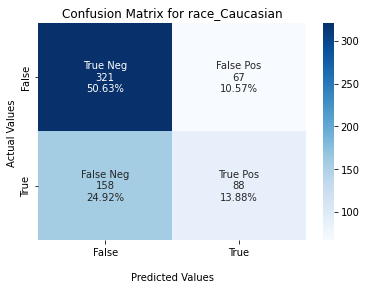

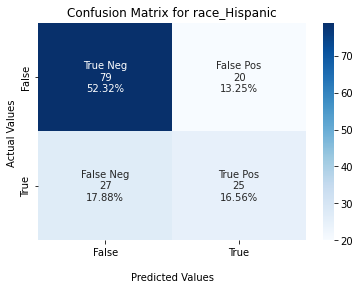

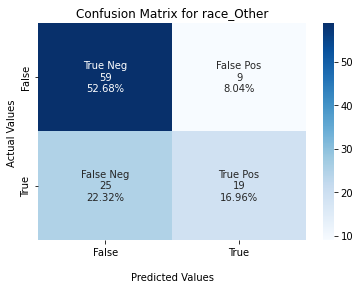

In [20]:
# confusion matrices for demo parity classifier
SetupMatrix(demo_parity,0)

In [ ]:
print("Demographic Parity Classifier Accuracy: " + str(demo_parity.score(X_test,y_test)))
print("Regular Logistic Regression Accuracy: " + str(clf.score(X_test,y_test)))

In [ ]:
print("Demographic Parity Classifier")
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(demo_parity, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(demo_parity, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(demo_parity, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(demo_parity, X)))

In [ ]:
print("Regular Logistic Regression")
print("P% score for African-American feature: " + str(p_percent_score(sensitive_column="race_African-American")(clf, X)))
print("P% score for Caucasian feature: " + str(p_percent_score(sensitive_column="race_Caucasian")(clf, X)))
print("P% score for Hispanic feature: " + str(p_percent_score(sensitive_column="race_Hispanic")(clf, X)))
print("P% score for Other Race feature: " + str(p_percent_score(sensitive_column="race_Other")(clf, X)))

**Comment**: As we can see there is a slight decrease in accuracy but a significant improvement in all of the p% scores except for the caucasian.

Equal Opportunity Classifier optimizes the following function:

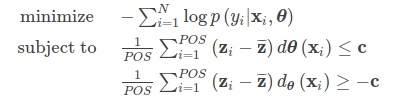

In [ ]:
from sklego.linear_model import EqualOpportunityClassifier

equal_opt = EqualOpportunityClassifier(sensitive_cols=["race_African-American","race_Caucasian","race_Hispanic","race_Other"], covariance_threshold=0.5,positive_target=True)
equal_opt.fit(X_train, y_train)

In [ ]:
equal_opt.predict(X_test)

In [ ]:
# confusion matrices for demo parity classifier
SetupMatrix(equal_opt,0)

In [ ]:
print("Equal Opportunity Classifier accuracy: " + str(equal_opt.score(X_test,y_test)))
print("Regular Logistic Regression Accuracy: " + str(clf.score(X_test,y_test)))

In [ ]:
print("Equal Opportunity Classifier")
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(equal_opt, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(equal_opt, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(equal_opt, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(equal_opt, X,Y)))

In [ ]:
print("Regular Logistic Regression")
print("Equal opportunity score for African-American feature: " + str(equal_opportunity_score(sensitive_column="race_African-American")(clf, X,Y)))
print("Equal opportunity score for Caucasian feature: " + str(equal_opportunity_score(sensitive_column="race_Caucasian")(clf, X,Y)))
print("Equal opportunity score for Hispanic feature: " + str(equal_opportunity_score(sensitive_column="race_Hispanic")(clf, X,Y)))
print("Equal opportunity score for Other Race feature: " + str(equal_opportunity_score(sensitive_column="race_Other")(clf, X,Y)))

**Comment**: Again using this classifier we get a slight hit on accuracy but we get improved equal opportunity score for every race except the caucasian. We are here comparing it to our logistic regression classifier since the equal opportunity classifier is a variant of logistic regression. 

# Neural Network vs Fair Classifier

Neural Network


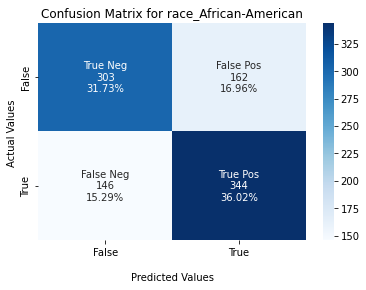

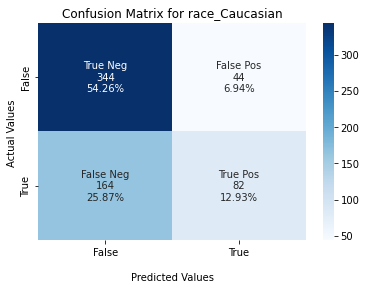

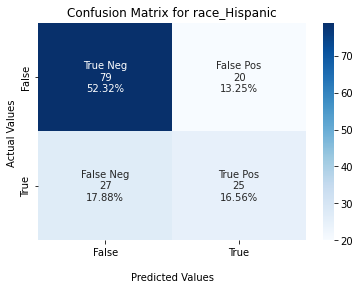

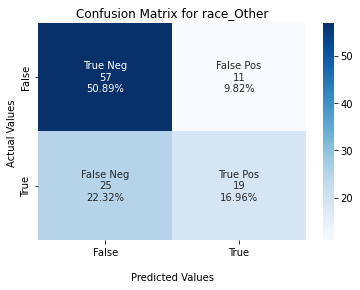

Neural Network accuracy:  0.6765658855438232


In [38]:
print("Neural Network")
SetupMatrix(model, 1)
score = model.evaluate(X_test, y_test, verbose=0)
print("Neural Network accuracy: ", score[1])

Equal Opportunity Classifier


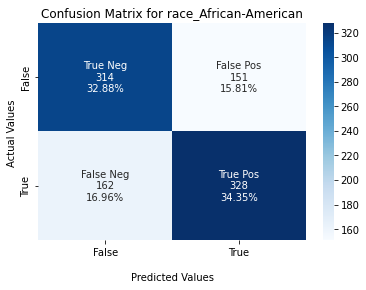

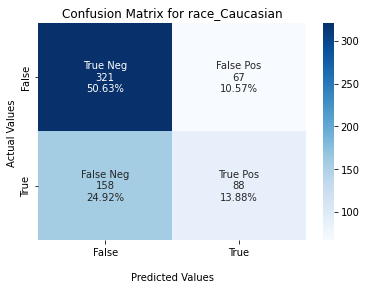

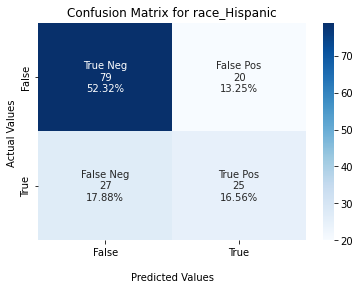

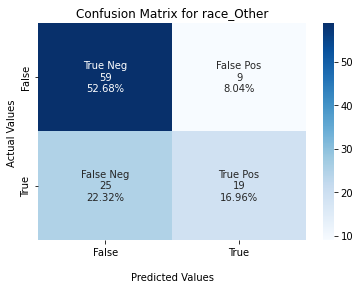

Equal Opportunity Classifier accuracy: 0.6657667386609071


In [35]:
print("Equal Opportunity Classifier")
SetupMatrix(equal_opt,0)
print("Equal Opportunity Classifier accuracy: " + str(equal_opt.score(X_test,y_test)))

Comparing the results obtained between the fair classifiers and the Neural Network, we can conclude that using the fair classifiers we will often obtain lower False Positive rates for most races, at the cost of an accuracy decrease, particularly on the True Positive rates compared to the usage of the Neural Network.

# Discussion and Conclusions

In order to build a fair classifier there are several methods to consider. One option is to pre-process the data set and remove sensitive features. This is hard, as discussed in the ProPublica article, because there might be many features in a dataset that are correlated to each other. Hence, a lot of features might need to be removed to completely get rid of sensitive data. Another approach to obtain a fair classifier is to put constraints on the classifier to e.g. force it to have the same true positive rate for all segments of a sensitive class (equal opportunity). Furthermore, there are also several definitions of fairness that all can not be fullfilled at the same time. 

In this project we have explored how to build classifiers that are fair considering demographic parity and equal opportunity for different races. We can see that our fair classifiers did perform better considering our chosen fairness metrics without losing much in accuracy. Trying to make a classifier more fair will always have a trade-off in accuracy since we are adding constraints.